## Stable Model Training

#### NOTES:  
* This is "NoGAN" based training, described in the DeOldify readme.
* This model prioritizes stable and reliable renderings.  It does particularly well on portraits and landscapes.  It's not as colorful as the artistic model.

In [23]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)

<DeviceId.GPU0: 0>

In [24]:
import os
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
from deoldify.generators import *
from deoldify.critics import *
from deoldify.dataset import *
from deoldify.loss import *
from deoldify.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile

## Setup

In [25]:
path = Path('data/imagenet/ILSVRC/Data/CLS-LOC-tiny')
path_hr = path
path_lr = path/'bandw'

proj_id = 'StableModel'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 2
pct_start = 1e-8

In [26]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, 
                             random_seed=None, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

def create_training_images(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)  
    
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

## Create black and white training images

Only runs if the directory isn't already created.

In [27]:
if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

## Pre-train generator

#### NOTE
Most of the training takes place here in pretraining for NoGAN.  The goal here is to take the generator as far as possible with conventional training, as that is much easier to control and obtain glitch-free results compared to GAN training.

### 64px

In [28]:
bs=88
sz=64
keep_pct=1.0

In [29]:
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


In [30]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)

In [31]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPre'))

In [32]:
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(1e-3))

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,6.527736,5.921489,02:31


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [33]:
learn_gen.save(pre_gen_name)

In [34]:
learn_gen.unfreeze()

In [35]:
learn_gen.fit_one_cycle(1, pct_start=pct_start,  max_lr=slice(3e-7, 3e-4))

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,5.071076,5.369720,01:55


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [36]:
learn_gen.save(pre_gen_name)

### 128px

In [37]:
bs=20
sz=128
keep_pct=1.0

In [38]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


In [39]:
learn_gen.unfreeze()

In [40]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,3.755867,3.749494,02:58


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [41]:
learn_gen.save(pre_gen_name)

### 192px

In [42]:
bs=8
sz=192
keep_pct=0.50

In [43]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


In [44]:
learn_gen.unfreeze()

In [45]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,time
0,3.042501,2.996791,03:12


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [46]:
learn_gen.save(pre_gen_name)

## Repeatable GAN Cycle

#### NOTE
Best results so far have been based on repeating the cycle below a few times (about 5-8?), until diminishing returns are hit (no improvement in image quality).  Each time you repeat the cycle, you want to increment that old_checkpoint_num by 1 so that new check points don't overwrite the old.  

In [127]:
old_checkpoint_num = 3
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

### Save Generated Images

In [128]:
bs=8
sz=192

In [129]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [130]:
save_gen_images()

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


### Pretrain Critic

##### Only need full pretraining of critic when starting from scratch.  Otherwise, just finetune!

In [112]:
if old_checkpoint_num == 0:
    bs=64
    sz=128
    learn_gen=None
    gc.collect()
    data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    learn_critic = colorize_crit_learner(data=data_crit, nf=256)
    learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))
    learn_critic.fit_one_cycle(6, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

In [113]:
bs=16
sz=192

In [114]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

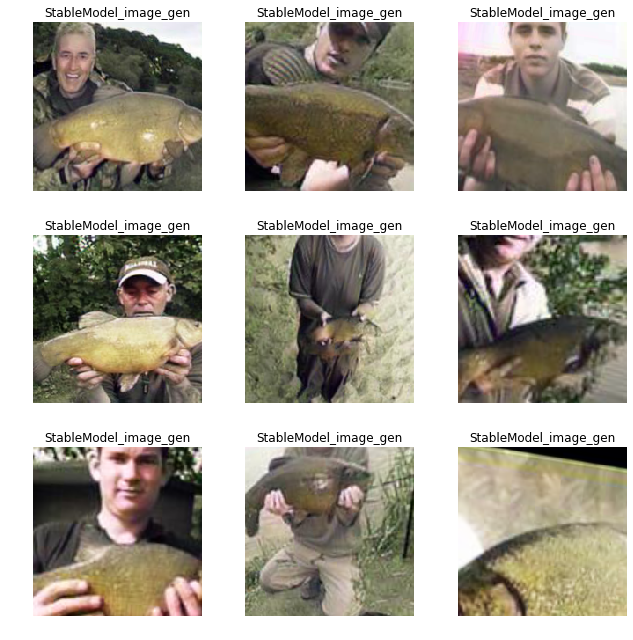

In [115]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [116]:
learn_critic = colorize_crit_learner(data=data_crit, nf=256).load(crit_old_checkpoint_name, with_opt=False)

In [117]:
learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))

In [118]:
learn_critic.fit_one_cycle(4, 1e-4)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.000000,0.000000,1.000000,04:27
1,0.000000,0.000000,1.000000,03:59
2,0.000000,0.000000,1.000000,04:21
3,0.000000,0.000000,1.000000,04:19


/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [119]:
learn_critic.save(crit_new_checkpoint_name)

### GAN

In [120]:
learn_crit=None
learn_gen=None
gc.collect()

66

In [121]:
lr=2e-5
sz=192
bs=5

In [122]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

In [123]:
learn_crit = colorize_crit_learner(data=data_crit, nf=256).load(crit_new_checkpoint_name, with_opt=False)

In [124]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [125]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=1))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=1))

#### Instructions:  
Find the checkpoint just before where glitches start to be introduced.  This is all very new so you may need to play around with just how far you go here with keep_pct.

In [126]:
learn.data = get_data(sz=sz, bs=bs, keep_pct=0.03)
learn_gen.freeze_to(-1)
learn.fit(1,lr)

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f

/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/opt/conda/lib/python3.6/site-packages/f